# MCRG Code following Swendsen Description circa 1982, Using Wolff's Algorithm to combat critical slowing down

In [1]:
from __future__ import division #safeguard against evil floor division

import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
import timeit
%load_ext line_profiler

np.set_printoptions(precision = 3,suppress=False)

## 2D Ising Model, periodic B.C., initial Hamiltonian contains only nearest neighbor interactions

$$\mathcal{H} = -\beta H_\Omega = K\sum_{\langle i,j\rangle} \sigma_i \sigma_j + h\sum_{i = 0}^{N_s} \sigma_i$$

### Block spin transform, scale factor = b 

In [2]:
def assignBlockSpin(total):
    '''Rule for assigning block spin value. Random tiebreaker'''
    if total > 0:
        s = 1;
    elif total < 0:
        s = -1;
    else:
        s = np.random.choice([-1,1])
    return s

In [3]:
def RGTransform(S,b):
    '''Take a spin config S and produce renormalized block spin config that 
    groups b*b spins together into one block. Does not modify input S'''
    L = S.shape[0];
    assert L//b >= 2, "Renormalized lattice will have linear dimension <=1"
    newS = np.empty([L//b, L//b],dtype=int)
    for j in np.arange(L//b):
        for i in np.arange(L//b):
            block = S[(b*i):(b*i+b),(b*j):(b*j+b)]
            total = np.sum(block)
            newS[i,j] = assignBlockSpin(total);    
    return newS

### First 7 short range even couplings

In [4]:
def N1Coupl(S):
    '''for spin field config S, 
    measure sum SiSj for i,j that are nearest neighbors, dir = (1,0)'''
    L = S.shape[0];
    assert L >=2, "Lattice too small for NN interaction"
    val = 0.0;
    for j in np.arange(L):
        for i in np.arange(L):
            val += S[i,j]*(S[i,(j+1)%L] + S[(i+1)%L,j])
    return val

In [5]:
def N2Coupl(S):
    '''for spin field config S, 
    measure sum SiSj for i,j that are next-nearest neighbors, dir = (1,1)'''
    L = S.shape[0];
    assert L >=2, "Lattice too small for next nearest neighbor interaction"
    val = 0.0;
    for j in np.arange(L):
        for i in np.arange(L):
            val += S[i,j]*(S[(i+1)%L,(j+1)%L] + S[(i-1)%L,(j+1)%L])
    return val

In [6]:
def N3Coupl(S):
    '''for spin field config S, 
    measure sum SiSj for i,j that are third-nearest neighbors,dir = (2,0)'''
    L = S.shape[0];
    assert L >=3, "Lattice too small for third nearest neighbor interaction"
    val = 0.0;
    for j in np.arange(L):
        for i in np.arange(L):
            val += S[i,j]*(S[i,(j+2)%L] + S[(i+2)%L,j])
    return val

In [7]:
def N4Coupl(S):
    '''for spin field config S, 
    measure sum SiSj for i,j that are 4th-nearest neighbors, dir = (2,1)'''
    L = S.shape[0];
    assert L >=3, "Lattice too small for 4th nearest neighbor interaction"
    val = 0.0;
    for j in np.arange(L):
        for i in np.arange(L):
            val += S[i,j]*(S[(i+1)%L,(j+2)%L] + S[(i+2)%L,(j+1)%L] 
                           +S[(i-1)%L,(j+2)%L] + S[(i-2)%L,(j+1)%L])
    return val

In [8]:
def N5Coupl(S):
    '''for spin field config S, 
    measure sum SiSj for i,j that are 5th-nearest neighbors,dir = (2,2)'''
    L = S.shape[0];
    assert L >=3, "Lattice too small for third nearest neighbor interaction"
    val = 0.0;
    for j in np.arange(L):
        for i in np.arange(L):
            val += S[i,j]*(S[(i+2)%L,(j+2)%L] + S[(i-2)%L,(j+2)%L])
    return val

In [9]:
def PlaqCoupl(S):
    '''for spin field config S, 
    measure sum SiSjSlSk for i,j,k,l that form 1 plaquette,'''
    L = S.shape[0];
    assert L >=2, "Lattice too small to form plaquettes"
    val = 0.0;
    for j in np.arange(L):
        for i in np.arange(L):
            val += S[i,j]*S[i,(j+1)%L]*S[(i+1)%L,(j+1)%L]*S[(i+1)%L,j]
    return val

In [10]:
def SubPlaqCoupl(S):
    '''for spin field config S, 
    measure sum SiSjSlSk for i,j,k,l that form 1 sublattice plaquette,'''
    L = S.shape[0];
    assert L >=3, "Lattice too small to form sublattice plaquettes"
    val = 0.0;
    for j in np.arange(L):
        for i in np.arange(L):
            val += S[(i+1)%L,j]*S[i,(j+1)%L]*S[(i-1)%L,j]*S[i,(j-1)%L]
    return val

In [11]:
def AllEvenCoupling(S):
    '''for spin field config S, 
    Integrate measurement of first 7 even correlation functions in one vector'''
    L = S.shape[0];
    assert L >=3, "Lattice too small to fit first 7 even couplings"
    val = np.zeros(7,dtype = float);
    for j in np.arange(L):
        for i in np.arange(L):
            val += [S[i,j]*(S[i,(j+1)%L] + S[(i+1)%L,j]), #nearest neighbor (1,0)
                    S[i,j]*(S[(i+1)%L,(j+1)%L] + S[(i-1)%L,(j+1)%L]), #next nearest neighbor (1,1)
                    S[i,j]*(S[i,(j+2)%L] + S[(i+2)%L,j]), #3rd nearest neighbor (2,0)
                    S[i,j]*(S[(i+1)%L,(j+2)%L] + S[(i+2)%L,(j+1)%L] 
                            +S[(i-1)%L,(j+2)%L] + S[(i-2)%L,(j+1)%L]),#4th nearest neighbor (2,1)
                    S[i,j]*(S[(i+2)%L,(j+2)%L] + S[(i-2)%L,(j+2)%L]),#5th nearest neighbor (2,2)
                    S[i,j]*S[i,(j+1)%L]*S[(i+1)%L,(j+1)%L]*S[(i+1)%L,j], # plaquette
                    S[(i+1)%L,j]*S[i,(j+1)%L]*S[(i-1)%L,j]*S[i,(j-1)%L]] # sublattice plaquette
    return val

### First 4 short range odd couplings

In [12]:
def Magnetization(S):
    L = S.shape[0];
    assert L >=1, "Lattice linear dim < 1"
    val = np.sum(S);
    return val

In [13]:
def TripletPlaq(S):
    L = S.shape[0];
    assert L >=2, "Lattice too small to have 3 spins on a plaquette"
    val = 0.0;
    for j in np.arange(L):
        for i in np.arange(L):
            val += S[i,j]*S[(i+1)%L,j]*S[(i+1)%L,(j+1)%L];
            val += S[i,j]*S[i,(j+1)%L]*S[(i-1)%L,(j+1)%L];
            val += S[i,j]*S[(i-1)%L,j]*S[(i-1)%L,(j-1)%L];
            val += S[i,j]*S[i,(j-1)%L]*S[(i+1)%L,(j-1)%L];
    return val

In [14]:
def TripletAngle(S):
    L = S.shape[0];
    assert L >=3, "Lattice too small to have 3 spins at an angle"
    val = 0.0;
    for j in np.arange(L):
        for i in np.arange(L):
            val += S[i,j]*S[(i+1)%L,j]*S[(i+2)%L,(j+1)%L];
            val += S[i,j]*S[i,(j+1)%L]*S[(i-1)%L,(j+2)%L];
            val += S[i,j]*S[(i-1)%L,j]*S[(i-2)%L,(j-1)%L];
            val += S[i,j]*S[i,(j-1)%L]*S[(i+1)%L,(j-2)%L];
    return val

In [15]:
def TripletRow(S):
    L = S.shape[0];
    assert L >=3, "Lattice too small have 3 spins in a row"
    val = 0.0;
    for j in np.arange(L):
        for i in np.arange(L):
            val += S[i,j]*(S[(i+1)%L,j]*S[(i+2)%L,j] \
                           + S[i,(j+1)%L]*S[i,(j+2)%L])
    return val

In [16]:
def AllOddCoupling(S):
    L = S.shape[0];
    assert L >=3, "Lattice too small to fit first 4 odd couplings"
    val = np.zeros(4,dtype = float);
    for j in np.arange(L):
        for i in np.arange(L):
            val += [0, #magnetization
                    S[i,j]*S[(i+1)%L,j]*S[(i+1)%L,(j+1)%L]+
                    S[i,j]*S[i,(j+1)%L]*S[(i-1)%L,(j+1)%L]+
                    S[i,j]*S[(i-1)%L,j]*S[(i-1)%L,(j-1)%L]+
                    S[i,j]*S[i,(j-1)%L]*S[(i+1)%L,(j-1)%L], #3 spin plaquette
                    S[i,j]*S[(i+1)%L,j]*S[(i+2)%L,(j+1)%L]+
                    S[i,j]*S[i,(j+1)%L]*S[(i-1)%L,(j+2)%L]+
                    S[i,j]*S[(i-1)%L,j]*S[(i-2)%L,(j-1)%L]+
                    S[i,j]*S[i,(j-1)%L]*S[(i+1)%L,(j-2)%L], # 3 spin angle
                    S[i,j]*(S[(i+1)%L,j]*S[(i+2)%L,j] + 
                            S[i,(j+1)%L]*S[i,(j+2)%L])] #3 spin row
    val[0] = np.sum(S);
    return val

### Clustering for Wolff Algorithm

In [17]:
def NNBonds(p):
    '''returns set of bonds that connect site p to its 4 nearest neighbors'''
    i = p[0]; j = p[1];
    nbrs = [(i,(j+1)%L),(i,(j-1)%L),((i+1)%L,j),((i-1)%L,j)]
    bonds = set();
    for n in nbrs:
        bonds.add(frozenset({p,n}))
    return bonds

In [18]:
def buildCluster(S):
    ''''Build Wolff cluster starting from random site for spin configuration S'''
    #random seed location
    L = S.shape[0];
    init = (np.random.choice(L),np.random.choice(L))
    Si = S[init[0],init[1]]
    
    #cluster starts with 1 element
    cluster = {init}
    
    #nearest neighbors make up the frontier
    bonds = NNBonds(init)
    
    #set of points already considered for adding to cluster
    checked = set();
    
    #while the set of fresh bonds is nonempty, do...
    while (len(bonds) > 0):
        if len(cluster) == Ns:
            break;
        #take out one bond in fresh bond set
        #frozenset ijbond represent unordered edge (i,j)
        ijbond = bonds.pop() 
        #add to list of bonds that have been checked
        checked.add(ijbond)
        #pick out element j from edge (i,j)
        jwrap = ijbond - cluster 
        #both i and j may already be in cluster, in this case skip to next iteration
        if len(jwrap) == 0:
            continue;
        #otherwise, only i in cluster already, we are left with j
        j = set(jwrap).pop() #convert to usable form
        Sj = S[j[0],j[1]]
        #if parallel to seed spin, activate bond with probability Pij
        if Sj == Si:
            r = np.random.random()
            if r < Pij:
                #add j to cluster, add nearest bonds of j to the fresh bond list
                #also remove bonds already considered from the fresh bond list
                cluster.add(j) 
                bonds |= NNBonds(j) 
                bonds -= checked 
    return cluster

### Integrated MC + RG simulation function

In [19]:
def Energy(S):
    '''Brute force Find energy of spin configuration S for sanity check'''
    L = S.shape[0];
    E = 0;
    for i in np.arange(L):
        for j in np.arange(L):
            E += K*S[i,j]*(S[i,(j+1)%L] + S[(i+1)%L,j])
    E += h*np.sum(S)
    return E

In [33]:
def RunMCRG(K,h):
    '''Run MCRG simulation to find y_t, y_h exponent, 
    keeping Nc_even and Nc_odd coupling terms'''
    print('running MCRG for linear size',L,'lattice.')
    print('Setting K =', K, " and h = ",h)

    #measurement accumulators for y_t
    evenK = np.zeros(7,dtype = float)
    evenK_1 = np.zeros(7,dtype = float)
    mix_11 = np.zeros((7,7),dtype=float)
    mix_01 = np.zeros((7,7),dtype=float)
    #measurement accumulators for y_h
    oddK = np.zeros(4,dtype = float)
    oddK_1 = np.zeros(4,dtype = float)
    mix_11_odd = np.zeros((4,4),dtype=float)
    mix_01_odd = np.zeros((4,4),dtype=float)
    
    #Run simulation
    k = 0;
    for n in np.arange(nmeas+nwarm):
        # Every MC n-loop, build a Wolff cluster and flip it
        # Result: A S-field config drawn with probability propto Boltzmann weight
        cluster = buildCluster(S)
        for p in cluster:
            S[p[0],p[1]] = -S[p[0],p[1]]
            
        #Sanity checks
        if n % interval == 0:
            energy[k] = Energy(S);
            clustersize[k] = len(cluster);
            k = k+1   
            
        # take measurements every (interval) steps if finished warmup
        if n % interval == 0 and n >= nwarm:
            S1 = RGTransform(S,b);
            evenK += AllEvenCoupling(S)
            evenK_1 += AllEvenCoupling(S1)
            oddK += AllOddCoupling(S)
            oddK_1 += AllOddCoupling(S1)
            #A*B = C, B is unknown, A is symmetric
            #Problem: C is not symmetric!?
            mix_11 += np.outer(AllEvenCoupling(S1),AllEvenCoupling(S1))
            mix_01 += np.outer(AllEvenCoupling(S1),AllEvenCoupling(S))
            mix_11_odd += np.outer(AllOddCoupling(S1),AllOddCoupling(S1))
            mix_01_odd += np.outer(AllOddCoupling(S1),AllOddCoupling(S))
                       
    #Results
    evenK /= ndata; evenK_1 /= ndata; mix_11 /= ndata; mix_01 /= ndata;
    oddK /= ndata; oddK_1 /= ndata; mix_11_odd /= ndata; mix_01_odd /= ndata;

    print('evenK = ',evenK)
    print('evenK_1 = ', evenK_1)
    print('mix_11 = ', mix_11)
    print('subtract ',np.outer(evenK_1,evenK_1))
    print('mix_01 = ', mix_01)
    print('subtract ',np.outer(evenK_1,evenK))
    MatA_even = mix_11-np.outer(evenK_1,evenK_1)
    MatC_even = mix_01-np.outer(evenK_1,evenK)
    print('MatA_even (lhs) = ',MatA_even)
    print('MatC_even (rhs) = ',MatC_even)
    print('\n')

    print('oddK = ',oddK)
    print('oddK_1 = ', oddK_1)
    print('mix_11 = ', mix_11_odd)
    print('subtract ', np.outer(oddK_1,oddK_1))
    print('mix_01 = ', mix_01_odd)
    print('subtract ', np.outer(oddK_1,oddK))
    #TODO: cancellation bad, how to avoid?
    MatA_odd = mix_11_odd-np.outer(oddK_1,oddK_1)
    MatC_odd = mix_01_odd-np.outer(oddK_1,oddK)
    print('MatA_odd (lhs) = ',MatA_odd)
    print('MatC_odd (rhs) = ',MatC_odd)
    print('\n');
    
    return MatA_even, MatC_even, MatA_odd, MatC_odd

In [34]:
def getExponent(MatA,MatC,Nc):
    LinRGMat = la.solve(MatA[0:Nc,0:Nc],MatC[0:Nc,0:Nc])
    print('linearized RG transformation = ',LinRGMat)
    lmbd = la.eigvals(LinRGMat);
    print('eigenvalues are',lmbd)
    amplitude = np.absolute(lmbd)
    print('eigenvalue amplitudes are',amplitude)
    #Only the eigenvalue with maximum amplitude is important.
    #This eigenvalue should generically be real
    imax = np.argmax(amplitude)
    y = np.log(lmbd[imax])/np.log(b)
    print('exponent y = ',y)
    return y

## Test for specific set of input parameters

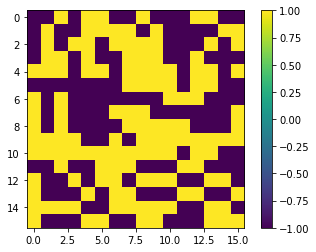

In [53]:
# Input Parameters
L = 16; #linear dimension of square lattice
Kc = np.arccosh(3)/4; # Critical temperature Kc assumed to be known
K = Kc; h = 0; #Start on Critical manifold
Pij = 1-np.exp(-2*K) # Wolff add probability
nwarm = 1000; #number of warm up Monte Carlo sweeps.
nmeas = 2000; #number of measurement Monte Carlo sweeps.
interval = 10; # Take data for correlation functions every (interval) MC-steps/site
# RG analysis setting
b = 2; #scaling factor

# Derived constants
Ns = L*L; #total number of grid points
ndata = nmeas//interval
energy = np.zeros((nmeas+nwarm)//interval,dtype=float)
clustersize = np.zeros((nmeas+nwarm)//interval,dtype=int)

#Initialize 2d spin field
S = np.random.choice([-1,1],(L,L))
#S = np.ones((L,L),dtype=int)
plt.imshow(S);plt.colorbar()

In [54]:
MatA_even, MatC_even, MatA_odd, MatC_odd = RunMCRG(K,h)

yt_arr = np.empty(7,dtype = complex);
yh_arr = np.empty(4, dtype = complex);

for i in np.arange(7):
    yt_arr[i] = getExponent(MatA_even,MatC_even,i+1)

for i in np.arange(4):
    yh_arr[i] = getExponent(MatA_odd,MatC_odd,i+1)

print("y_t array = ", yt_arr)
print("y_h array = ", yh_arr)

running MCRG for linear size 16 lattice.
Setting K = 0.4406867935097715  and h =  0
evenK =  [378.68 349.26 333.74 651.38 314.44 161.22 133.7 ]
evenK_1 =  [ 97.22  92.74  88.76 175.    85.7   40.86  36.88]
mix_11 =  [[ 9760.24  9394.96  9080.16 17942.16  8829.36  4169.52  3815.84]
 [ 9394.96  9091.92  8812.4  17436.56  8597.84  4021.84  3719.6 ]
 [ 9080.16  8812.4   8588.48 17000.    8400.4   3901.2   3619.36]
 [17942.16 17436.56 17000.   33716.96 16677.44  7708.72  7173.6 ]
 [ 8829.36  8597.84  8400.4  16677.44  8275.6   3796.72  3544.4 ]
 [ 4169.52  4021.84  3901.2   7708.72  3796.72  1809.68  1650.96]
 [ 3815.84  3719.6   3619.36  7173.6   3544.4   1650.96  1560.64]]
subtract  [[ 9451.728  9016.183  8629.247 17013.5    8331.754  3972.409  3585.474]
 [ 9016.183  8600.708  8231.602 16229.5    7947.818  3789.356  3420.251]
 [ 8629.247  8231.602  7878.338 15533.     7606.732  3626.734  3273.469]
 [17013.5   16229.5   15533.    30625.    14997.5    7150.5    6454.   ]
 [ 8331.754  7947.8

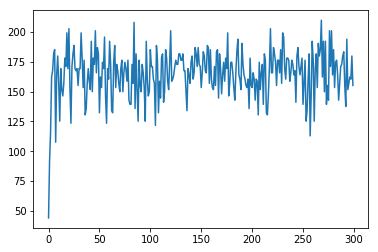

In [55]:
plt.plot(energy)

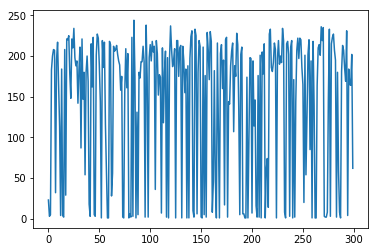

In [56]:
plt.plot(clustersize)

In [43]:
np.mean(clustersize[140:400-1])/Ns

0.54541015625

In [52]:
filename = input('save data to file:')
f = open(filename,'w')
print("================== SETTINGS ==================",file= f)
print("L = ", L, "\n",file = f)
print("K = ", K, "\n",file = f)
print("h = ", h, "\n",file = f)
print("b = ", b, "\n",file = f)
print("nwarm = ", nwarm, "\n",file = f)
print("nmeas = ", nmeas, "\n",file = f)
print("interval = ", interval, "\n",file = f)
print("ndata = ", ndata, "\n",file = f)
print("================== RESULTS ===================", file = f)
print("avg cluster size = ",np.mean(clustersize)/Ns, "\n",file = f)
print("y_t array = ", yt_arr,"\n",file = f)
print("y_h array = ", yh_arr,"\n",file = f)
f.close()

save data to file:data.out
